In [9]:
import os
import sys
sys.path.append("../")
sys.path.append("../src")
from src.envs import CatcherEnv
from src.agent.CRAR import CRAR
from omegaconf import OmegaConf
from tqdm import tqdm 
import torch 
result_path = "/data3/bumjin_store/repro/rep1/results/22-06-16/17-55-13"
flags = OmegaConf.load(os.path.join(result_path, "config.yaml"))
logger = None
env = CatcherEnv() 
agent = CRAR(env.observation_space, env.action_space, flags, logger)
agent.load(os.path.join(result_path, "checkpoint_0.4.tar"))

In [88]:
obs_preprocessing = lambda x : x.unsqueeze(0) 

states = [] 
rewards = []
embeddings = [] 
transitions = []
episodes = 1000
for i in tqdm(range(episodes)):
    state = env.reset()
    done = False 
    transitions.append([])
    while not done:
        state = obs_preprocessing(torch.tensor(state, device=flags.device)).unsqueeze(0)
        action = agent.act(state)
        ns, r, done, info = env.step(action)
        states.append(state)
        rewards.append(r)
        encoded = agent.encoder(state)
        abstract_state_action = torch.cat((encoded, torch.tensor([[action]]).to(flags.device)),1 )
        transition = agent.transition_net(abstract_state_action)
        reward_pre = agent.reward_net(abstract_state_action)
        qs = agent.q_net(encoded)
        embeddings.append([encoded, abstract_state_action, transition, reward_pre, qs])
        state = ns 
        ns_encoded = obs_preprocessing(torch.tensor(ns, device=flags.device)).unsqueeze(0)
        ns_encoded = agent.encoder(ns_encoded)
        if not done:        
            transitions[-1].append([encoded, ns_encoded])
    

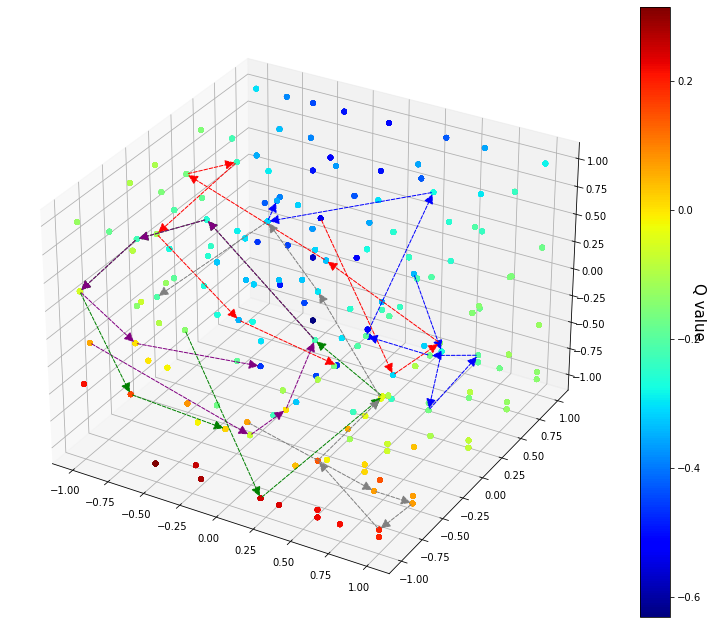

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.proj3d import proj_transform
import numpy as np 
import matplotlib as mpl

class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 


fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
xdata = [e[0][0,0].item() for e in embeddings]
ydata = [e[0][0,1].item() for e in embeddings]
zdata = [e[0][0,2].item() for e in embeddings]
qdata = [e[4][0,0].item() for e in embeddings]

p = ax.scatter3D(xdata, ydata, zdata, c=qdata, cmap='jet')
cbar = fig.colorbar(p, ax=ax, fraction=0.046,)
cbar.ax.set_ylabel('Q value', rotation=270, fontsize=15)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D, 'arrow3D', _arrow3D)

colors = ['red', 'blue', 'green' , 'grey', 'purple']
i = 0 
for transition_in_ep in transitions:
    if i< len(colors):
        for t1, t2 in transition_in_ep:
            t1 = t1.cpu().detach().numpy()[0]
            t2 = t2.cpu().detach().numpy()[0]
            x1, y1, z1 = t1
            x2, y2, z2 = t2
            ax.arrow3D(x1,y1,z1,
                x2-x1,y2-y1,z2-z1,
                mutation_scale=20,
                arrowstyle="-|>",
                color=colors[i],
                # arrowstyle="-",
                linestyle='dashed')
        # break
    i +=1
plt.tight_layout()
plt.show()